# Factoring with D-Wave Quantum Computers

In the [Leap](https://cloud.dwavesys.com/leap) factoring demo, you saw how a D-Wave quantum computer factored an integer by running a multiplication circuit in reverse.

This notebook demonstrates how you can solve a [constraint satisfaction problem](https://docs.ocean.dwavesys.com/en/stable/concepts/csp.html) (CSP) on a quantum computer with the example of factoring. 

1. [Factoring as a Constraint Satisfaction Problem](#Factoring-as-a-Constraint-Satisfaction-Problem) describes the factoring problem as an example CSP.
2. [Formulating the Problem for a D-Wave Quantum Computer](#Formulating-the-Problem-for-a-D-Wave-Quantum-Computer) shows how such CSPs can be formulated for solution on a quantum computer.
3. [A Simple Example](#A-Simple-Example) codes a small CSP to clarify the solution technique.
4. [Factoring on the Quantum Computer](#Factoring-on-the-Quantum-Computer) codes a factoring problem for solution on a D-Wave quantum computer.
5. [Further Information](#Further-Information) details some points touched on in previous sections and examines more closely the results returned from the quantum computer. 

This notebook  should help you understand both the techniques and [Ocean software](https://github.com/dwavesystems) tools used for solving CSPs on D-Wave quantum computers.

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

# Factoring as a Constraint Satisfaction Problem
The [complexity class](https://en.wikipedia.org/wiki/Complexity_class) for classical integer factoring is believed to be between P and NP-hard.  Although research has yielded algorithms that perform faster than the intuitive trial division, including Fermat's algorithm, Pollard's two algorithms, and sieve algorithms, it's still an open question whether a classical algorithm exists that can factor in [polynomial time](https://en.wikipedia.org/wiki/Time_complexity). For quantum computing, Shor's algorithm runs in polynomial time (D-Wave quantum computers do not run this algorithm).  

This notebook solves factoring on a D-Wave quantum computer by formulating it as a *[constraint satisfaction problem](https://docs.ocean.dwavesys.com/en/stable/concepts/csp.html)*. CSPs require that all a problem's variables be assigned values that result in the satisfying of all constraints. For factoring, the problem's constraints are that the two variables representing factors, $a$ and $b$, be assigned only natural numbers and that their multiplication be equal to the factored number, $P$. 

Among CSPs are hard problems well suited to solution on quantum computers. For example, the map-coloring problem is to color all regions of a map such that any two regions sharing a border have different colors (see a D-Wave quantum computer solve a four-color map-coloring problem here: [Ocean software examples](https://docs.ocean.dwavesys.com/en/stable/getting_started.html#examples)). The job-shop scheduling problem is to schedule multiple jobs done on several machines with constraints on the machines' execution of tasks. You can apply the solution technique shown here to many CSPs. 

# Formulating the Problem for a D-Wave Quantum Computer
How can you formulate the factoring problem in a way that a quantum computer can understand? 

D-Wave quantum computers solve [binary quadratic models](https://docs.ocean.dwavesys.com/en/stable/concepts/bqm.html) (BQM), the [Ising](#https://en.wikipedia.org/wiki/Ising_model) model traditionally used in statistical mechanics and its computer-science equivalent, the [quadratic unconstrained binary optimization](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) (QUBO) problem. Given $N$ variables $x_1,...,x_N$, where each variable $x_i$ can have binary values $0$ or $1$, the quantum computer finds assignments of values that minimize the QUBO

$\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$,

where $q_i$ and $q_{i,j}$ are configurable (linear and quadratic) coefficients. To formulate a problem for a D-Wave quantum computer is to program $q_i$ and $q_{i,j}$ so that assignments of $x_1,...,x_N$ also represent solutions to the problem.

There are different ways to formulate the factoring problem as a BQM. Formulation A starts with an intuitive one. 

## Formulation A
<div class="alert alert-warning" role="alert" style="margin: 10px">Skip this subsection if you prefer to move on to what this notebook codes. Or try implementing it yourself as an exercise, although this is not the recommended formulation.</div>

You can solve an equation, say $x+1=2$, by minimizing the square of the subtraction of one side from another, $\min_x[2-(x+1)]^2$. Intuitively such a minimization seeks the shortest distance between the sides, which occurs at equality, with the square eliminating negative distance. 

For a factored number, $P$, to be equal to its factors, $a, b$, you can solve  $P=ab$ with the minimization

$\min_{a,b}(P-ab)^2$.

To solve this minimization on a quantum computer, you would represent the integers with equivalent binary numbers; for example, integer $a$ is represented as $a_0 + 2a_1 + 4a_2 +... +2^ma_m$, where variables $a_i$ can have binary values $0$ or $1$. 

D-Wave quantum computers solve binary *quadratic* models so this now-binary minimization should not have terms with higher order than $a_ib_j$. However, squaring $(P-ab)$ introduces non-quadratic terms for problems of any decent size. You would therefore use [order reduction](https://docs.dwavesys.com/docs/latest/handbook_reformulating.html) techniques on all higher terms. For example, by introducing a new variable $x_k=a_0b_2$, you can replace a non-quadratic term such as $8b_0b_2a_0^2$ with quadratic term $8b_0x_k$ (notice that $a_0^2=a_0$), and do so repeatedly until all terms are linear or quadratic. 

You would now have a BQM. Programming its coefficients on a D-Wave quantum computer would solve the factoring problem. 

## Formulation B

Formulation A above produces a BQM in three steps: (1) state equation $P=ab$ as a minimization, (2) represent integers as binary numbers, and (3) reduce to quadratic.
   
An alternative is to express the constraints of the problem with Boolean logic. This technique is very versatile: modern computing is built on Boolean gates, the scope of addressable problems is immense. The implementation below follows these steps:

1. Express $P=ab$ as a CSP with a binary multiplication circuit.
2. Convert to a BQM.
3. Program the quantum computer with the BQM's coefficients.

Some differences between the two formulations are noted below.

# A Simple Example
This section illustrates the steps of Formulation B above on a very simple problem: a circuit with two switches that turns on a light. 

<img src="images/example_light_and_switches.png" width=300x/>

## Step 1: Express as a CSP with Boolean Logic

You can express the problem of how to turn on the light as a CSP with a single constraint: for light $L$ to shine, both switches $SW_1$ and $SW_2$ must be on. In logic, you express this constraint as the [conjunction](https://en.wikipedia.org/wiki/Logical_conjunction) $L = SW_1 \wedge SW_2$. 

Unlike real-world CSPs, which can have thousands of constraints to satisfy simultaneously, the one constraint of this trivial CSP also expresses its solution. Although you forgo a surprise ending, it's instructive to run through the steps needed to "solve the problem".

First, express the CSP with binary variables:

* Switches $SW_1$ and $SW_2$ are represented by binary variables $x_1, x_2$ with values 1 when on and 0 when off.
* Light $L$ is represented by binary variable $x_3$ with value 1 if it's shining and 0 if not.
* Logical conjunction, $L = SW_1 \wedge SW_2$, is expressed in binary format as $x_3 = x_1 \wedge x_2$. 

The graphic below shows an AND gate and its [truth table](https://en.wikipedia.org/wiki/Truth_table), which gives the gate's output, $x_3$, for all combinations of inputs $x_1, x_2$. 

<img src="images/AND_TruthTableandGate.png" width=300x/>

It's clear from the table that the problem's constraint, $L = SW_1 \wedge SW_2$, and the AND gate's operation, $x_3 = x_1x_2$, are equivalent. You can express the constraint as an AND gate. 

## Step 2: Convert to a BQM 
The quantum computer solves binary quadratic models. Express the light-circuit CSP as a BQM.

An advantage of Formulation B is that BQMs are known for logic gates ([D-Wave system documentation](https://docs.dwavesys.com/docs/latest/handbook_reformulating.html) gives the BQMs for common Boolean gates and [Ocean documentation](https://docs.ocean.dwavesys.com/en/stable/getting_started.html#examples) has usage examples). More than one BQM can represent an AND gate: it's just a polynomial of binary variables, with only linear and quadratic terms, that has lowest value for variables that match rows of the AND truth table; for example, 

$3x_3 + x_1x_2 - 2x_1x_3 - 2x_2x_3$.

To see that this BQM represents the AND gate, you can set its variables to the values of the AND truth table (e.g., $x_1, x_2, x_3=0,0,0$) and to non-valid values (e.g., $ x_1, x_2, x_3=0,0,1$). All the former should produce lower values than any of the latter. 

Use `itertools` to produce all possible configurations of $ x_1, x_2, x_3$, and then print these (under "x1, x2, x3") to the right of the BQM's value (under "E"), sorted from low to high.

Run the cell below by pressing the **Run** button with your mouse in the cell. 

In [106]:
import itertools

configurations = []
for (x1, x2, x3) in  list(itertools.product([0, 1], repeat=3)):
     E = 3*x3+x1*x2-2*x1*x3-2*x2*x3
     configurations.append((E, x1, x2, x3))

configurations.sort()

print("E, x1, x2, x3")
configurations

E, x1, x2, x3


[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 1),
 (1, 0, 1, 1),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (3, 0, 0, 1)]

Use Ocean's [dimod](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/sdk_index.html) to generate a BQM, then print out the BQM's coefficients, the inputs used to program a D-Wave quantum computer. As noted, more than one BQM can represent an AND gate, so the BQM generated here does not have to match the one written above.

In [107]:
from dimod.generators import and_gate

and_bqm = and_gate("x1", "x2", "x3")

print("Linear coefficients:\n\t{}".format(
      {key: val for key, val in and_bqm.linear.items()}))
print("Quadratic coefficients:\n\t{}".format(
      {key: val for key, val in and_bqm.quadratic.items()}))

Linear coefficients:
	{'x1': np.float64(0.0), 'x2': np.float64(0.0), 'x3': np.float64(3.0)}
Quadratic coefficients:
	{('x2', 'x1'): np.float64(1.0), ('x3', 'x1'): np.float64(-2.0), ('x3', 'x2'): np.float64(-2.0)}


## Step 3: Solve By Minimization 
Lastly, solve the problem by finding variable values that produce the BQM's lowest values. For real-world problems, with large numbers of variables and constraints, minimizing a BQM is hard: this is where a quantum computer comes in handy. 

The next section, which solves a factoring problem, uses a D-Wave quantum computer. For this trivial example, instead of using a D-Wave quantum computer as the *sampler* (the component used to minimize a BQM), use one of Ocean software's test samplers. Ocean's [dimod](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/sdk_index.html) provides one that simply returns the BQM's value for every possible assignment of variable values.

In [108]:
from dimod import ExactSolver

sampler = ExactSolver()

Print the BQM's values ("energy") in ascending order. Note that they are indeed lowest for valid assignments&mdash;values under "x1, x2, x3" match rows of the AND truth table&mdash;and higher for non-valid ones. (The `num_oc.`column, which specifies the number of returned occurrences for a particular solution, is irrelevant here.) 

In [109]:
solution = sampler.sample(and_bqm)

print(solution)

  x1 x2 x3 energy num_oc.
0  0  0  0    0.0       1
1  1  0  0    0.0       1
3  0  1  0    0.0       1
5  1  1  1    0.0       1
2  1  1  0    1.0       1
4  0  1  1    1.0       1
6  1  0  1    1.0       1
7  0  0  1    3.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


Note: to understand the examples of this Jupyter Notebook, it's enough to understand that samplers such as D-Wave quantum computers find solutions that minimize a BQM. If you want further details on that minimization (the "energy" here and "E" previously), see below under [Further Information](#Further-Information).

# Factoring on the Quantum Computer
This section solves a factoring problem as a CSP, following the same steps used for the simple problem of the light circuit:

1. Express factoring as a CSP using Boolean logic operations.
2. Convert to a BQM.
3. Minimize the BQM.

## Step 1: Express Factoring as Multiplication Circuit
Again start by expressing the problem with Boolean logic gates, in this case a multiplication circuit.

This example factors integer 21 which is represented as a 6-bit binary number. To express the factoring equation, $P = ab$, in Boolean logic, use a simple 3-bit multiplier (a circuit that takes two 3-bit binary numbers and outputs their 6-bit binary product).  

Note: Binary multipliers are made with logic gates like the AND gate used above. Understanding the factoring example and its application to solving CSPs does not require an understanding of binary multiplication. If you do want to know more, see below under [Further Information](#Further-Information).

In [110]:
P = 21  

bP = "{:06b}".format(P)    # "{:06b}" formats for 6-bit binary
print(bP)

010101


## Step 2: Convert to a BQM

Express the multiplication circuit as a BQM that provides the coefficients used to program the problem on a D-Wave quantum computer.

Ocean's [dimod](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/sdk_index.html) has generators for Boolean gates that includes a BQM for a multiplication circuit.  

In [111]:
from dimod.generators import multiplication_circuit 

bqm = multiplication_circuit(3)

print("BQM has {} variables: \n\t{}".format(len(bqm.variables), list(bqm.variables)))

BQM has 27 variables: 
	['a0', 'b0', 'p0', 'b1', 'and0,1', 'b2', 'and0,2', 'a1', 'and1,0', 'p1', 'carry1,0', 'and1,1', 'sum1,1', 'carry1,1', 'and1,2', 'sum1,2', 'carry1,2', 'a2', 'and2,0', 'p2', 'carry2,0', 'and2,1', 'p3', 'carry2,1', 'and2,2', 'p4', 'p5']


The next cell visualizes a BQM for a $3X3$ multiplication circuit. Each node of the graph represents a variable; these include P and its factors as binary numbers, and some internal variables of the multiplication circuit.

<img src="images/bqm_3x3_mult.png" width=700x/>

As in the [Leap](https://cloud.dwavesys.com/leap) factoring demo, the D-Wave quantum computer factors this integer by running a multiplication circuit in reverse. Below, fix the variables of the multiplication circuit's BQM to the binary digits of the factored number P (represented by binary variables P0, P1...P6). This modifies the BQM by removing the known variables and updating neighboring values accordingly.

In [112]:
p_vars = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']

# Convert P from decimal to binary
fixed_variables = dict(zip(reversed(p_vars), "{:06b}".format(P)))
fixed_variables = {var: int(x) for(var, x) in fixed_variables.items()}

# Fix product variables
for var, value in fixed_variables.items():
    bqm.fix_variable(var, value)
    
print("BQM has {} non-fixed variables: \n\t{}".format(len(bqm.variables), list(bqm.variables)))

BQM has 21 non-fixed variables: 
	['a0', 'b0', 'b1', 'and0,1', 'b2', 'and0,2', 'a1', 'and1,0', 'carry1,0', 'and1,1', 'sum1,1', 'carry1,1', 'and1,2', 'sum1,2', 'carry1,2', 'a2', 'and2,0', 'carry2,0', 'and2,1', 'carry2,1', 'and2,2']


## Step 3: Submit to the Quantum Computer
Lastly, solve the BQM by finding variable assignments that produce its lowest values. Here you use a D-Wave quantum computer. 

### Setting Up a Solver
Set up a D-Wave quantum computer as your solver in the standard way described in the Ocean documentation's [Configuring Access to D-Wave Solvers](https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html). 

Set a *sampler*, the component used to find variable values that minimize the binary quadratic model representing the problem. Here, use a D-Wave quantum computer, but Ocean tools are designed to swap in and out samplers with ease. For example you might first run a classical sampler on your computer's CPU during testing, and only once your code is ready, submit the problem for solution on the quantum computer.   

In [113]:
from dwave.samplers import SimulatedAnnealingSampler

# Use a D-Wave system as the sampler
sampler = SimulatedAnnealingSampler() 

print("Simulated annealing was selected...")

Simulated annealing was selected...


Mapping between the problem graph&mdash;the multiplication circuit's graph with nodes labeled "a0", "b0" etc.&mdash;to the D-Wave QPU's numerically indexed qubits, is known as *minor-embedding*. A problem can be minor embedded onto the QPU in a variety of ways and this affects solution quality and performance. 

Ocean software provides a variety of embedding tools. This example uses [dwave-system](https://docs.ocean.dwavesys.com/en/stable/docs_system/sdk_index.html) *EmbeddingComposite()* that automatically handles minor-embedding.

In [114]:
# from dwave.system import EmbeddingComposite

# embedding_sampler = EmbeddingComposite(sampler)

When the D‑Wave quantum computer solves a problem, it uses quantum phenomena such as superposition and tunneling to explore all possible solutions simultaneously and find a set of the best ones. Because the sampled solution is probabilistic, returned solutions may differ between runs. Typically, when submitting a problem to a quantum computer, you ask for many samples, not just one. This way, you see multiple answers and reduce the probability of settling on a suboptimal answer.

In the code below, `num_reads` should provide enough samples to make it likely a valid answer is among them.

In [115]:
# sampleset = embedding_sampler.sample(bqm, num_reads=100, label='Notebook - Factoring')

sampleset = sampler.sample(bqm, num_reads=100, label='Notebook - Factoring')

print("Best solution found: \n",sampleset.first.sample)

Best solution found: 
 {'a0': np.int8(1), 'a1': np.int8(1), 'a2': np.int8(0), 'and0,1': np.int8(1), 'and0,2': np.int8(1), 'and1,0': np.int8(1), 'and1,1': np.int8(1), 'and1,2': np.int8(1), 'and2,0': np.int8(0), 'and2,1': np.int8(0), 'and2,2': np.int8(0), 'b0': np.int8(1), 'b1': np.int8(1), 'b2': np.int8(1), 'carry1,0': np.int8(1), 'carry1,1': np.int8(1), 'carry1,2': np.int8(1), 'carry2,0': np.int8(0), 'carry2,1': np.int8(0), 'sum1,1': np.int8(1), 'sum1,2': np.int8(0)}


### Viewing the Solution
Convert back from binary numbers to integers. Because quantum computing is probabilistic, there is a slight chance that in many executions of this example, your execution might return an incorrect solution. Rerunning the previous cell will most likely produce a correct answer. 

In [119]:
# To see helper functions, select Jupyter File Explorer View from the Online Learning page
from helpers.convert import to_base_ten
 
a, b = to_base_ten(sampleset.first.sample)

print("Given integer P={}, found factors a={} and b={}".format(P, a, b))

Given integer P=21, found factors a=3 and b=7


# Summary

This Jupyter Notebook showed how you can formulate a constraint satisfaction problem for solution on a quantum computer using Ocean software. You solved a factoring problem as an example of one proposed solution technique.   

You saw two ways of formulating the factoring problem. Formulation A is intuitive and direct, but conversion of large integers to binary introduces (a) increasing weights per bit, $2^ma_m$, and (b) in the squaring of $(P-ab)$, terms of higher order that need to be reduced to quadratic. These affect performance. Formulation B, using binary gates, is a useful technique in general. The modularity of binary gates provides some benefits for minor-embedding: repeated small units that can be tiled onto the QPU's topology.       

# Further Information

This section provides more information on binary multiplication, minimizing BQMs, sampling for solutions, and minor-embedding.  

## Binary Multiplication

Binary number multiplication works the same way that multiplication is taught in school. That is, for two 3-bit numbers $a_2a_1a_0$ and $b_2b_1b_0$, the multiplication is written as

\begin{array}{rrrrrr}
&  &  &  &  & \\
&  &  & a_{2} & a_{1} & a_{0}\\
\times &  &  & b_{2} & b_{1} & b_{0}\\
\hline 
& 0 & 0 & b_{0}a_{2} & b_{0}a_{1} & b_{0}a_{0}\\
& 0 & b_{1}a_{2} & b_{1}a_{1} & b_{1}a_{0} & 0\\
& b_{2}a_{2} & b_{2}a_{1} & b_{2}a_{0} & 0 & 0\\
\hline 
p_{5}  & p_{4} & p_{3} & p_{2} & p_{1} & p_{0}\\
\end{array}

where each $p_i$ is the sum of the values in the $i$-th column; for example, $p_2 = b_{0}a_{2} + b_{1}a_{1} + b_{2}a_{0}$.

A binary multiplication circuit represents each of the nine products $b_ia_j$ as an AND gate and each of the three summations of 5-bit partial products as an adder.

<img src="images/BinaryMultiplicationCircuit_gates.png" width=400x/>

The simple implementation used by this example does not support two's complement, carry lookahead, or any other nifty features. If you're curious, [this Wikipedia article](https://en.wikipedia.org/wiki/Binary_multiplier) is a great place to start.

In the circuit below, given inputs 011 (3) and 111 (7), the circuit outputs 010101 (21). 

<img src="images/21.jpg" width=400x/>

## Minimizing BQMs

A fundamental rule of physics is that everything tends to seek a minimum energy state. Objects slide down hills; hot things cool down over time. This behavior is also true in the world of quantum physics. To solve optimization problems on a D-Wave quantum computer, you frame them as energy-minimization problems, and solve them through the physics of the QPU, which finds low-energy states.

D-Wave quantum computers solve a subset of binary quadratic models, the Ising and quadratic unconstrained binary optimization (QUBO) problems, by finding assignments of variables that correspond to minimum energy.

For the Ising model, $N$ variables $\bf s=[s_1,...,s_N]$ correspond to physical Ising spins, where $h_i$ are the biases and $J_{i,j}$ the couplings (interactions) between spins.

$\text{Ising:} \qquad
  E(\bf{s}|\bf{h},\bf{J})
  = \left\{ \sum_{i=1}^N h_i s_i +
  \sum_{i<j}^N J_{i,j} s_i s_j  \right\}
  \qquad\qquad s_i\in\{-1,+1\}$

For the QUBO model, $N$ binary variables represented as an upper-diagonal matrix $Q$, where diagonal terms are the linear coefficients and the nonzero off-diagonal terms the quadratic coefficients.

$\text{QUBO:} \qquad E(\bf{x}| \bf{Q})
    =  \sum_{i\le j}^N x_i Q_{i,j} x_j
    \qquad\qquad x_i\in \{0,1\}$

The BQM you formulate to express a problem sets up qubits representing the binary variables on the QPU. The QPU finds low-energy states of the qubits. In most cases, the lower the energy, the better the solution. 

## Samples and Solutions

[Samplers](https://docs.ocean.dwavesys.com/en/stable/concepts/samplers.html) are processes that sample from low energy states of an [objective function](https://docs.ocean.dwavesys.com/en/stable/concepts/index.html), which is a mathematical expression of the energy of a system. A binary quadratic model (BQM) sampler samples from low energy states in models such as those defined by an Ising model traditionally used in statistical mechanics or its computer-science equivalent, the QUBO, and returns an iterable of samples, in order of increasing energy.

The D-Wave quantum computer returns a [dimod.SampleSet](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampleset.html) object that contains all of the information about the generated samples and has some access methods. 

View the energy (rounded to two decimal places) of the samples, using a `dict` mapping pairs `(a, b)` to information about them.

In [117]:
from collections import OrderedDict

def response_to_dict(sampleset):
    results_dict = OrderedDict()
    for sample, energy in sampleset.data(['sample', 'energy']):
        a, b = to_base_ten(sample)
        if (a, b) not in results_dict:
            results_dict[(a, b)] = round(energy, 2)
            
    return results_dict

results = response_to_dict(sampleset)
results

OrderedDict([((np.int8(3), np.int8(7)), np.float64(0.0)),
             ((np.int8(7), np.int8(3)), np.float64(0.0)),
             ((np.int8(5), np.int8(5)), np.float64(1.0)),
             ((np.int8(1), np.int8(5)), np.float64(1.0)),
             ((np.int8(4), np.int8(5)), np.float64(1.0)),
             ((np.int8(5), np.int8(4)), np.float64(1.0)),
             ((np.int8(5), np.int8(1)), np.float64(1.0))])

Create a scatter plot of the samples and their energies, showing that the lowest energy states correspond to correct answers.

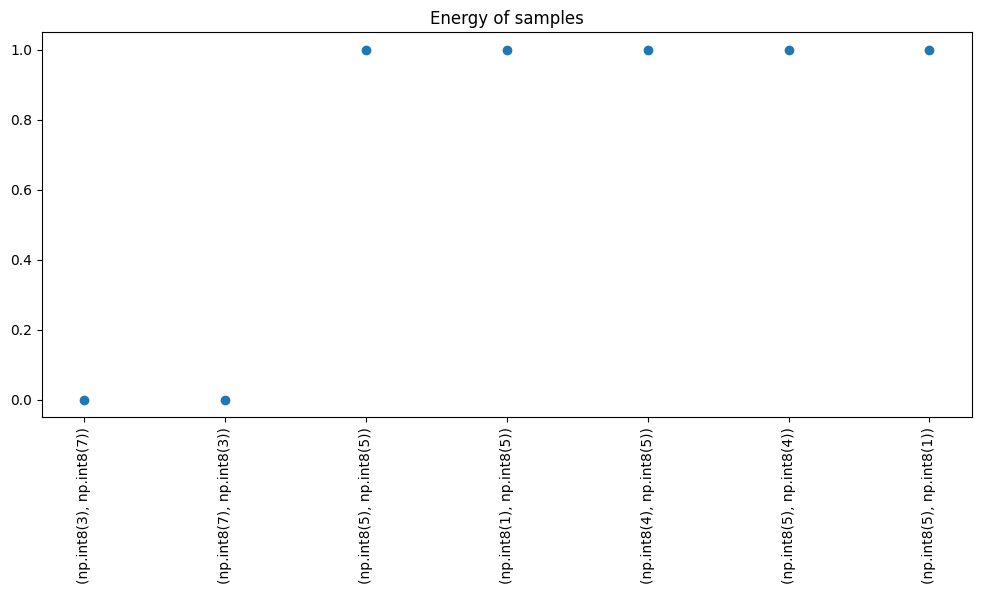

In [118]:
from helpers import draw
draw.energy_of(results)

Copyright &copy; 2020 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>